In [2]:
"""
TODO:

17.group per events , users ✓ 
18.columns to drop ✓
19.target encoding city region ✓

* Subs
* events
*
* NN @keras
* features 
* hyperpar tune + grid search // random search
* 
* cat cols with catboost &lgbm
*pep8

""";

In [3]:
import os
import time
import numpy as np
import pandas as pd
import datetime

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef as mcc

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 65)
pd.set_option('display.max_columns', 55)

C:\Users\python\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
printHeads = 1
plotGraphs = 1

In [5]:
if printHeads:
    display(os.listdir())

['.ipynb_checkpoints',
 'catboost_info',
 'Datahack2019_short.ipynb',
 'Dh2019 0.0.ipynb',
 'Dh2019 0.2.ipynb',
 'Dh2019 before upload.ipynb',
 'events.ipynb',
 'ground_truth_public.csv',
 'ground_truth_secret.csv',
 'log.xlsx',
 'monday.JPG',
 'test_accounts.csv',
 'test_events.csv',
 'test_events_gr_usr.csv',
 'test_subscriptions.csv',
 'test_users.csv',
 'Thumbs.db',
 'train_accounts.csv',
 'train_events.csv',
 'train_events_gr_usr.csv',
 'train_subscriptions.csv',
 'train_users.csv']

In [6]:
if printHeads and 0:
    csvs = (x for x in os.listdir() if x.endswith('.csv'))
    for a in csvs:
        print(a)
        display(pd.read_csv(a,nrows = 5).head(3))
        print("-----------------"*7)

In [7]:
Loadcsvs = 1
if Loadcsvs:
    train_accounts = pd.read_csv('train_accounts.csv',parse_dates=[2,4,5,10],index_col=[0])
    train_users = pd.read_csv('train_users.csv',parse_dates=[4,8])
    #train_events = pd.read_csv('train_events',parse_dates=[0]) 
    train_subscriptions = pd.read_csv('train_subscriptions.csv')

    #test
    test_accounts = pd.read_csv('test_accounts.csv',parse_dates=[2,4,5,10],index_col=[0])
    test_users = pd.read_csv('test_users.csv',parse_dates=[4,8])
    #test_events = pd.read_csv('test_events.csv',parse_dates=[0])
    test_subscriptions = pd.read_csv('test_subscriptions.csv')

C:\Users\python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\python\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
# dataframe info stats
def stats(data):
    
    maxx = []
    minn = []
    for i in data.columns:
        maxx.append(data[i].value_counts().max())
        minn.append(data[i].value_counts().min())

    return pd.DataFrame(
        {'nunique': data.nunique(),
         'len': len(data),
         'nunique/len': data.nunique()/len(data),
         'types':data.dtypes,
         'Nulls' : data.isna().sum(),
         'Nullpercent' : data.isna().sum()/len(data),
         "Value counts Max": maxx,
         'Value counts Min':minn 
        },
        columns = ['nunique', 'len', 'nunique/len','types','Nulls',
                   'Nullpercent',"Value counts Max",'Value counts Min']).\
        sort_values(by ='nunique',ascending = False)

In [9]:
# values in test not exist in train 
def traintestdiffs(df_train,dt_test,numofunique=100):
    for x in dt_test.columns:
        if (df_train[x].nunique() < numofunique):
            if np.setdiff1d(dt_test[x].astype(str).unique(),df_train[x].astype(str).unique()).size > 0 :
                print(x," ::: ",np.setdiff1d(dt_test[x].astype(str).unique(),df_train[x].astype(str).unique()))

# accounts

In [10]:
if printHeads:
    display(stats(train_accounts))

,nunique,len,nunique/len,types,Nulls,Nullpercent,Value counts Max,Value counts Min
trial_start,1295949,1361978,9.515198e-01,datetime64[ns],0,0.000000,6,1
created_at,1293250,1361978,9.495381e-01,datetime64[ns],0,0.000000,5,1
account_name,512268,1361978,3.761206e-01,object,0,0.000000,4540,1
subscription_started_at,32124,1361978,2.358628e-02,datetime64[ns],1329806,0.976378,3,1
company_size,4224,1361978,3.101372e-03,float64,1078496,0.791860,32621,1
region,3578,1361978,2.627062e-03,object,88500,0.064979,54021,1
churn_date,2845,1361978,2.088874e-03,datetime64[ns],1359096,0.997884,3,1
collection_21_days,1469,1361978,1.078578e-03,int64,0,0.000000,1336499,1
mrr,382,1361978,2.804744e-04,float64,1316375,0.966517,18033,1
country,236,1361978,1.732774e-04,object,19676,0.014447,314456,1


In [11]:
if printHeads:
    display(train_accounts.head().T)

account_id,1.0,2.0,3.0,4.0,5.0
account_name,"Gardner, Barron and Keller",Dunn Ltd,Boone Inc,"Christian, Carroll and Davis",Brooks-Oliver
created_at,2019-01-01 00:01:15,2019-01-01 00:01:52,2019-01-01 00:03:12,2019-01-01 00:04:11,2019-01-01 00:04:21
plan_id,NaN,NaN,NaN,NaN,NaN
trial_start,2019-01-01 00:01:15,2019-01-01 00:01:52,2019-01-01 00:03:12,2019-01-01 00:04:11,2019-04-04 11:09:12
churn_date,NaT,NaT,NaT,NaT,NaT
churn_reason,NaN,NaN,NaN,NaN,NaN
time_diff,11,NaN,-6,NaN,-5
region,New South Wales,New Jersey,Louisiana,Tel Aviv,North Carolina
country,AU,US,US,IL,US
subscription_started_at,NaT,NaT,NaT,NaT,NaT


0    1328072
1      33906
Name: lead_score, dtype: int64


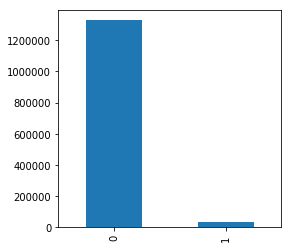

In [12]:
if plotGraphs:
    print(train_accounts.lead_score.value_counts())
    train_accounts['lead_score'].value_counts().plot(kind = 'bar',figsize = (4, 4))

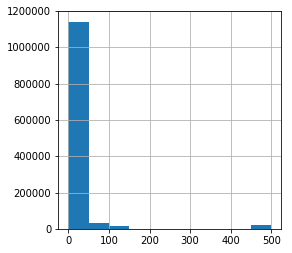

In [13]:
if plotGraphs:
    train_accounts['max_team_size'].hist(figsize = (4, 4))
    plt.show()

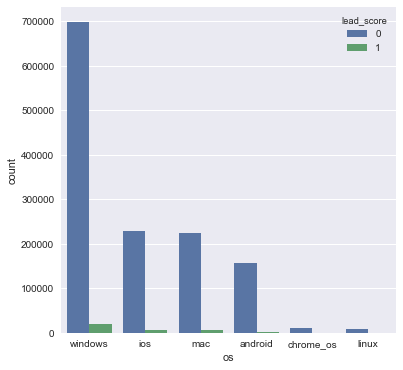

In [14]:
if plotGraphs:
    sns.set(rc={'figure.figsize':(6,6)})
    ax = sns.countplot(x="os", data=train_accounts, hue = 'lead_score',
                       order=train_accounts['os'].value_counts().iloc[:6].index)

In [15]:
# check unique values in object type columns
if printHeads:
    for x in train_accounts.columns:
        if (train_accounts[x].nunique() < 100 and train_accounts[x].dtype == 'O'):
            print (x," -- " ,train_accounts[x].unique())

device  --  ['desktop' 'mobile' 'tablet']
os  --  ['windows' 'ios' 'android' 'chrome_os' 'mac' 'linux' nan 'blackberry']
browser  --  ['microsoft edge' nan 'chrome' 'firefox' 'safari' 'generic browser'
 'opera' 'internet explorer' 'qq browser' 'blackberry' 'ucbrowser'
 'micromessenger' 'weibo']
payment_currency  --  ['AUD' 'USD' 'EUR' 'CAD' 'GBP' nan 'BRL' 'MXN' 'INR']
industry  --  [nan 'Other' 'Design' 'Finance' 'Business Owner' 'Project Management'
 'Accounting' 'Education' 'IT' 'Administrative' 'Software Development'
 'Operations' 'Creative' 'Events' 'Software Engineering' 'Consulting'
 'Sales' 'Marketing' 'Customer Support' 'Business Development'
 'Product Management' 'Real estate' 'Research' 'Manufacturing'
 'Architecture' 'BI' 'Data' 'Healthcare' 'HR' 'Venture Capital'
 'Real Estate' 'Legal' 'Construction']
utm_cluster_id  --  ['orders' nan 'todos' 'crm' 'client_projects' 'internal_projects'
 'product_roadmap' 'time_management' 'Other' 'tech' 'hr'
 'calendar_planning' 'marketing

In [16]:
def prepro(df,targetenco = False):
    
    
    if targetenco:
        def targetenc(df,column):
            #lead score only in train data 
            oss = train_accounts.groupby(column)['lead_score'].agg(['sum','count']).sort_values(('count'),ascending=False)
            oss['Lead_score_rate'] = oss['sum']/oss['count']
            d = dict(zip(oss.index,oss.Lead_score_rate))
            df[column] = df[column].map(d).fillna(0)
            return df

        #df = targetenc(df,'country')
        df = targetenc(df,'os')
    
    else:
        catcols = ['region', 'country']
        df = df.drop(catcols,axis = 1)
        
    
#acc drop cols
    
    ToDrop = ['account_name','has_logo']
    df = df.drop(ToDrop,axis = 1)
    
#fillna
    
    # churn date not null but reason yes => missing reason fill 0
    df.loc[df['churn_date'].notnull() & df['churn_reason'].isna(), 'churn_reason'] = 0

    # churn date and reason  null => didnt churned -1/-99
    df.loc[df['churn_date'].isna() & df['churn_reason'].isna(), 'churn_reason'] = -1
    
    #fill -1
    MinusOne = ['plan_id','max_team_size', 'min_team_size','mrr','company_size']
    df[MinusOne] = df[MinusOne].fillna(-1)
    
    # started at check
    df['churn_date'] = df['churn_date'].fillna(value=pd.to_datetime('1/1/2020'))
    df['subscription_started_at'] = df['subscription_started_at'].fillna(value=pd.to_datetime('1/1/2010'))

    # fill unknown
    unknowncols = ['browser','os','utm_cluster_id','industry','payment_currency','user_goal','user_description']
    df[unknowncols] = df[unknowncols].fillna('UnKnown')
    
    # cat to numbers -- team size
    TsDict = {
    
                '0':0,
                '2':2,
                '2-5':3.5,
                '4':4,
                '8':8,
                '6-10':8.1,
                '11-15':13.1,
                '16-25':20.5,
                '26-50':38.1,
                '51-100':75.5, 
                '101-500':300.5,
                '500 ':500,
                np.nan:-7
            }
    TsDict.update(dict.fromkeys(['1', '1-1', 'Solo yo','Moi uniquement','Nur ich','Apenas eu'],1))
    df['team_size'] = df['team_size'].map(TsDict).fillna(df['team_size']).astype('float64')
    
# date to int 
    
    datecols = ['created_at','trial_start','churn_date','subscription_started_at']
    for col in datecols:
        df[col] = pd.to_datetime(df[col]).astype(np.int64)
    
    # ToDo change (50)
    df['time_diff'] = df['time_diff'].fillna(50)
    
# create dummies 
    
    ColsToDummy = ['device','os','browser','payment_currency','industry','utm_cluster_id','user_goal','user_description','team_size']
    #df = pd.get_dummies(df, columns=ColsToDummy)
    
    return df


train_accounts_pr = prepro(train_accounts)
test_accounts_pr = prepro(test_accounts)
print('done');

done


# users

In [17]:
if printHeads:
    display(stats(train_users))

,nunique,len,nunique/len,types,Nulls,Nullpercent,Value counts Max,Value counts Min
user_id,2132527,2140258,9.963878e-01,float64,0,0.000000,3,1
created_at,1907750,2140258,8.913645e-01,datetime64[ns],0,0.000000,18,1
became_active_at,1645773,2140258,7.689601e-01,datetime64[ns],373835,0.174668,14,1
email,1485324,2140258,6.939930e-01,object,0,0.000000,244,1
account_id,1360568,2140258,6.357028e-01,float64,0,0.000000,240,1
name,410109,2140258,1.916166e-01,object,0,0.000000,229441,1
city,59327,2140258,2.771956e-02,object,434777,0.203142,24140,1
region,3726,2140258,1.740912e-03,object,420863,0.196641,73823,1
country,237,2140258,1.107343e-04,object,328158,0.153326,466804,1
serial_number,234,2140258,1.093326e-04,float64,0,0.000000,1363949,1


In [18]:
def usersprepro(df):
    
#users drop cols
    
    ToDrop = ['has_phone','has_photo','email','country','serial_number','region','city','name']
    df = df.drop(ToDrop,axis = 1)
    
#fillna

    # fill unknown
    unknowncols = ['device','os','browser','seniority','language']
    df[unknowncols] = df[unknowncols].fillna('UnKnown')
    
    #fill data na TODO : change 112020
    df['became_active_at'] = df['became_active_at'].fillna(value=pd.to_datetime('1/1/2020'))
    df['Created_Active_delta'] = (df['became_active_at']-df['created_at'])
    
    #date to int ## TODO : check 
    datecols = ['created_at','became_active_at']
    for col in datecols:
        df[col] = pd.to_datetime(df[col]).astype(np.int64)
    
    # ToDo change (50)
    df['time_diff'] = df['time_diff'].fillna(50)
    
    # create dummies
    ColsToDummy = ['device','os','browser','seniority','language']
    #df = pd.get_dummies(df, columns=ColsToDummy)
    
    
    return df

train_users_pr = usersprepro(train_users)
test_users_pr = usersprepro(test_users)
print('Done')

Done


In [19]:
if printHeads:
    display(stats(train_users_pr))

,nunique,len,nunique/len,types,Nulls,Nullpercent,Value counts Max,Value counts Min
user_id,2132527,2140258,9.963878e-01,float64,0,0.0,3,1
created_at,1907750,2140258,8.913645e-01,int64,0,0.0,18,1
became_active_at,1645774,2140258,7.689606e-01,int64,0,0.0,373835,1
account_id,1360568,2140258,6.357028e-01,float64,0,0.0,240,1
Created_Active_delta,524547,2140258,2.450859e-01,timedelta64[ns],0,0.0,8696,1
time_diff,42,2140258,1.962380e-05,float64,0,0.0,503059,1
browser,13,2140258,6.074034e-06,object,0,0.0,1148122,2
language,9,2140258,4.205101e-06,object,0,0.0,1518939,1
os,8,2140258,3.737867e-06,object,0,0.0,974584,8
device,4,2140258,1.868934e-06,object,0,0.0,1339083,12844


In [20]:
# check unique values in object type columns
if printHeads:
    for x in train_users.columns:
        if (train_users[x].nunique() < 100 and train_users[x].dtype == 'O'):
            print (x," -- " ,train_users[x].nunique())

device  --  3
os  --  7
browser  --  12
language  --  8
seniority  --  3


In [21]:
if printHeads:
    display(train_users_pr.head().T)

,0,1,2,3,4
account_id,1,2,2,3,4
user_id,1,2,3,4,5
created_at,1546300697000000000,1546300664000000000,1546301844000000000,1546300809000000000,1546300976000000000
is_admin,1,1,0,1,1
pending,0,0,0,0,0
enabled,1,1,1,1,1
became_active_at,1546300876000000000,1546300913000000000,1546305281000000000,1546300992000000000,1546301051000000000
time_diff,11,-5,-5,-6,50
device,desktop,mobile,mobile,desktop,mobile
os,windows,ios,android,windows,android


In [22]:
# group users by account
def groupusers(df):
    
    # get admin id for each account , if more than one take first
    admins = df[['account_id','user_id']][df.is_admin==1]\
        .set_index('account_id').add_prefix('admin_')
    # For now TODO 
    admins = admins[~admins.index.duplicated(keep='first')]
    
    # get first user for each account
    first_user_per_account = df[['account_id','user_id','became_active_at']].\
        sort_values(by=['account_id','user_id','became_active_at'],ascending = True).\
        groupby('account_id').first().add_prefix('first_')

    # group users per account
    grouped_df = df.groupby(by='account_id')\
                .agg({'user_id':['count'],
                      'became_active_at':['min','max'],
                      'Created_Active_delta':['min','max'],
                      'created_at':['min','max'],
                      'enabled':['mean','max'],
                      'is_admin':['mean'],
                      })
    grouped_df.columns = ['_'.join(col) for col in grouped_df.columns]
    
    # merge 
    merged = grouped_df.merge(admins,left_index=True,right_index=True,how = 'inner',validate="1:1")\
              .merge(first_user_per_account,left_index=True,right_index=True,how = 'inner',validate="1:1")
    # TODO check
    colsToUse = ['user_id_count', 'became_active_at_min', 'became_active_at_max',
       'Created_Active_delta_min', 'Created_Active_delta_max',
       'created_at_min', 'created_at_max', 'enabled_mean', 'enabled_max',
       'is_admin_mean', 
       'first_became_active_at']
    
    merged = merged[colsToUse]
    return merged


train_users_gr= groupusers(train_users_pr)
print(len(train_users_gr))
test_users_gr= groupusers(test_users_pr)
print(len(test_users_gr))

print('done')

1308854
68822
done


# events

Events csv file too large.
I Load it in other notebook (events.ipynb). group it by account and user and export it to smaller csv.
Here i load the grouped csv.

In [23]:
train_events_gr_usr = pd.read_csv('train_events_gr_usr.csv',parse_dates=[26,27])
test_events_gr_usr = pd.read_csv('test_events_gr_usr.csv',parse_dates=[26,27])

In [24]:
if printHeads:
    display(train_events_gr_usr.head().T)

,0,1,2,3,4
account_id,1,2,2,2,3
user_id,1,2,3,76014,4
total_events,53,1185,242,1,72
column_events,0,0,0,0,0
board_events,0,0,0,0,1
num_of_boards,0,0,0,0,1
count_kind_columns,0,0,0,0,0
content_events,0,0,0,0,1
group_events,0,0,0,0,0
invite_events,0,0,0,0,0


In [26]:
if printHeads:
    display(stats(train_events_gr_usr))

,nunique,len,nunique/len,types,Nulls,Nullpercent,Value counts Max,Value counts Min
user_id,2245265,2404956,0.933599,float64,0,0.0,482,1
account_id,1504644,2404956,0.625643,float64,0,0.0,198,1
total_events,13137,2404956,0.005462,float64,0,0.0,155722,1
TotalinFirstThird,9221,2404956,0.003834,float64,0,0.0,163023,1
web_events,9003,2404956,0.003744,int64,0,0.0,1028078,1
empty_events,8139,2404956,0.003384,int64,0,0.0,419827,1
TotalinSecondThird,6677,2404956,0.002776,float64,0,0.0,915126,1
TotalinLastThird,5266,2404956,0.002190,float64,0,0.0,448313,1
desktop_app_events,3699,2404956,0.001538,int64,0,0.0,2386607,1
non_communicating_events,3470,2404956,0.001443,float64,0,0.0,922104,1


### group per account

In [27]:
# group events from per account-user to account
def eventsperaccount(df):
    
    #sum all numeric values per account
    accounts_events_sum = df.groupby('account_id').sum().drop('user_id',axis=1)
    
    #group Non-sum features
    accounts_evenst_dates = df.groupby(by=['account_id'])\
                .agg({ 'max_date':['max'],
                      'min_date':['min'],
                      'nunique_date':['max','min','mean'],
                      'UsageLength':['max','min','mean'],
                      'user_id':['nunique']
                      })
    accounts_evenst_dates.columns = ['_'.join(col) for col in accounts_evenst_dates.columns]    
    
    #rename columns
    Names = {"max_date_max":"max_event_date",
         "min_date_min":"min_event_date",
         "user_id_nunique":"numOfusers"}
    accounts_evenst_dates.rename(columns=Names,inplace=True)

    #join both DataFrames
    merged_acc_events = accounts_events_sum.merge(accounts_evenst_dates,how='inner',left_index=True,right_index=True,validate='1:1')
    
    #time to int TODO:check
    datecols = ['max_event_date','min_event_date']
    for col in datecols:
        merged_acc_events[col] = pd.to_datetime(merged_acc_events[col]).astype(np.int64)
        
    return merged_acc_events


train_events_gr_acc = eventsperaccount(train_events_gr_usr)
test_events_gr_acc = eventsperaccount(test_events_gr_usr)
print('done')

done


# subscriptions

In [28]:
if printHeads:
    display(train_subscriptions.head().T)

,0,1,2,3,4
event_happened_at,2019-01-09 22:37:05,2019-01-10 09:44:45,2019-01-29 08:33:46,2019-01-30 16:24:50,2019-01-31 03:14:01
subscription_id,1,2,4,5,6
account_id,38427,24270,23467,196680,133677
plan_id,264,236,231,204,820
event_type,RECURRING,CONTRACT_CHANGE,FREE_DAYS_WERE_GIVEN,CHARGE,CHARGE
invoice_charge_amount,645.48,0,0,145,276
prev_plan_id,264,234,NaN,NaN,NaN
status,NaN,SUCCESS,NaN,NaN,NaN
status_reason,NaN,NaN,NaN,NaN,NaN
currency,AUD,GBP,NaN,EUR,AUD


In [29]:
if printHeads:
    display(stats(train_subscriptions))

,nunique,len,nunique/len,types,Nulls,Nullpercent,Value counts Max,Value counts Min
event_happened_at,112008,131055,0.854664,object,0,0.000000,12,1
next_charge_date,67541,131055,0.515364,object,12179,0.092930,176,1
transaction_date,60088,131055,0.458495,object,3788,0.028904,88,1
subscription_id,46370,131055,0.353821,float64,0,0.000000,175,1
account_id,32716,131055,0.249636,float64,0,0.000000,193,1
invoice_charge_amount_usd,14581,131055,0.111259,float64,3850,0.029377,49871,1
invoice_charge_amount,6912,131055,0.052741,float64,3660,0.027927,50061,1
mrr_gain,785,131055,0.005990,float64,47118,0.359528,25747,1
plan_id,127,131055,0.000969,float64,13,0.000099,16228,1
prev_plan_id,113,131055,0.000862,float64,36163,0.275938,13849,1


In [30]:
#preprocessing for subscription TODO
def subsprepro(df):
    start_time = time.time()
    
    #group by account #TODO currency,payment type
    subsGrouped  = df.groupby(by='account_id')\
                .agg({'invoice_charge_amount':['sum'],
                      'event_type':['nunique'],
                      'mrr_gain':['sum'],
                      'event_happened_at':['min','max','count']
                      #'currency':pd.Series.mode,
                      #'payment_type':pd.Series.mode
                      });
    subsGrouped.columns = ['_'.join(col) for col in subsGrouped.columns]
    
    
    #subsGrouped = pd.get_dummies(subsGrouped,columns = ['currency_mode', 'payment_type_mode'])
    
    print (time.time()-start_time,' Seconds')
    return subsGrouped


train_subscriptions_pr = subsprepro(train_subscriptions)
test_subscriptions_pr = subsprepro(test_subscriptions)
print('done')

16.006547927856445  Seconds
1.0809390544891357  Seconds
done


# visualization

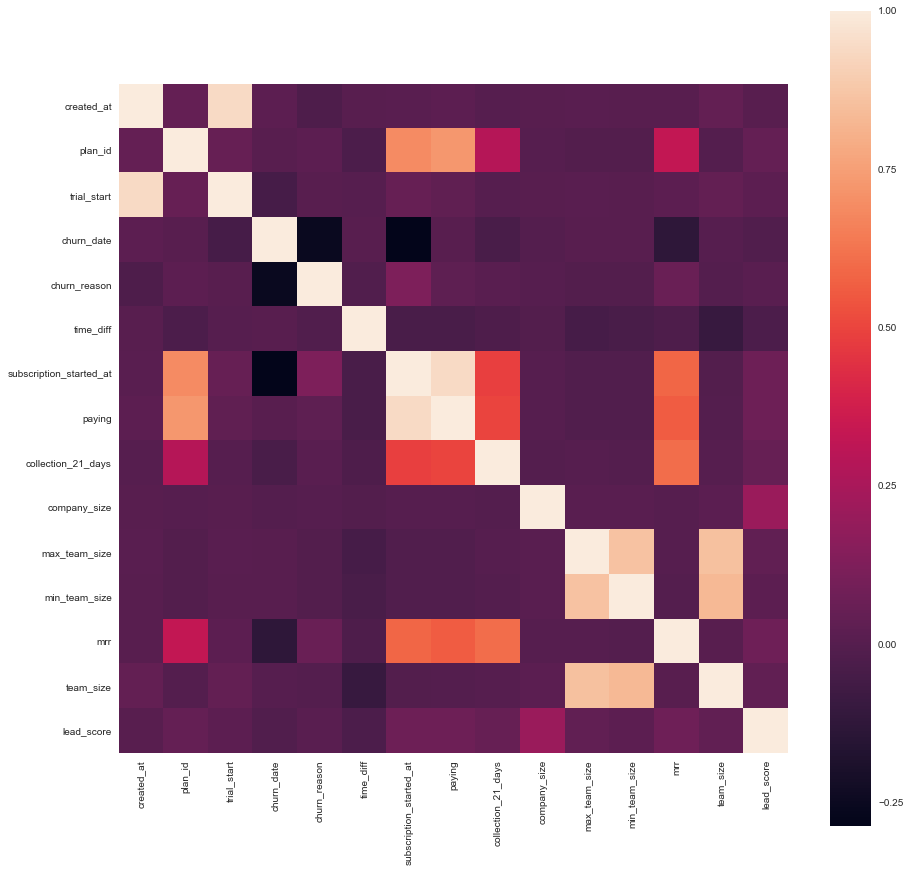

In [31]:
if plotGraphs:
    corrmat = train_accounts_pr.corr()
    fig = plt.figure(figsize = (15, 15))

    sns.heatmap(corrmat, square = True)
    plt.show()

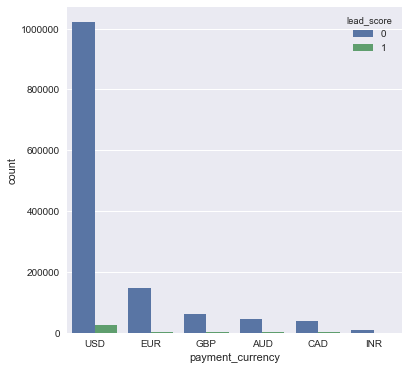

In [34]:
if plotGraphs:
    ax = sns.countplot(x="payment_currency", data=train_accounts_pr,hue = 'lead_score',
                       order=train_accounts_pr['payment_currency'].value_counts().iloc[:6].index)

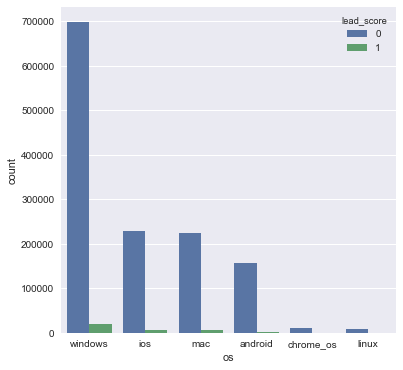

In [36]:
if plotGraphs:
    ax = sns.countplot(x="os", data=train_accounts_pr,hue = 'lead_score',
                       order=train_accounts_pr['os'].value_counts().iloc[:6].index)

## merge tables 

In [37]:
#drop duplicates
train_accounts_pr = train_accounts_pr.loc[~train_accounts_pr.index.duplicated(keep='first')]

#train
panel_train = train_accounts_pr.merge(train_users_gr,left_index=True,right_index=True,how = 'inner',validate="1:1").\
                                merge(train_events_gr_acc,left_index=True,right_index=True,how = 'inner',validate="1:1").\
                                merge(train_subscriptions_pr,left_index=True,right_index=True,how = 'left',validate="1:1")

#test
panel_test = test_accounts_pr.merge(test_users_gr,left_index=True,right_index=True,how = 'inner',validate="1:1").\
                            merge(test_events_gr_acc,left_index=True,right_index=True,how = 'inner',validate="1:1").\
                            merge(test_subscriptions_pr,left_index=True,right_index=True,how = 'left',validate="1:1")

#after join fillna in subscription dafaframe
colstofill = train_subscriptions_pr.columns.values

panel_train[colstofill] = panel_train[colstofill].fillna(0,axis=1)
panel_test[colstofill] = panel_test[colstofill].fillna(0,axis=1)

In [38]:
if printHeads:
    display(panel_train.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1308579 entries, 1.0 to 1433659.0
Data columns (total 74 columns):
created_at                   1308579 non-null int64
plan_id                      1308579 non-null float64
trial_start                  1308579 non-null int64
churn_date                   1308579 non-null int64
churn_reason                 1308579 non-null float64
time_diff                    1308579 non-null float64
subscription_started_at      1308579 non-null int64
paying                       1308579 non-null int64
device                       1308579 non-null object
os                           1308579 non-null object
browser                      1308579 non-null object
collection_21_days           1308579 non-null int64
company_size                 1308579 non-null float64
payment_currency             1308579 non-null object
max_team_size                1308579 non-null float64
min_team_size                1308579 non-null float64
industry                     1308

None

In [39]:
# train eval split
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']

y = panel_train['lead_score']
X = panel_train.select_dtypes(include=numerics).drop('lead_score',axis = 1)


X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state=17) ## test_size = 0.000001

# test split

X_test = panel_test.select_dtypes(include=numerics)

# Fit model

In [40]:
"""
X_train
X_val
y_train
y_val

---------
X_test
y_pred

""";

In [41]:
def printMetrics(test,prediction):
    
    print(confusion_matrix(test, prediction))
    print('#'*100)
    print(classification_report(test, prediction))
    
#-----------------------------

def runModel (modelname,X_train, y_train,X_test,y_test,printaccuracy=True):
    
    start_time = time.time()
    
    y_pred = modelname.fit(X_train, y_train).predict(X_test)
    
    if printaccuracy:
        
        print(modelname.__class__.__name__ +' running time : {} seconds '.format(time.time() - start_time ))
        print('Accuracy of '+ modelname.__class__.__name__ +' on training set: {:.3f}'
         .format(modelname.score(X_train, y_train)))
        print('Accuracy of '+ modelname.__class__.__name__ +' on test set: {:.3f}'
         .format(modelname.score(X_test, y_test)))
    
    return y_pred,modelname

In [42]:
XGB = Rf = NB =  1

LGBM = 1

CB = 0

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

if NB:
# Feature Scaling
    sc_X = StandardScaler()
    X_train_tr = sc_X.fit_transform(X_train)
    X_val_tr = sc_X.transform(X_val)

    classifier = GaussianNB()

    y_pred,Model = runModel(classifier,X_train_tr, y_train,X_val_tr,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    NB_mcc = mcc(y_val, y_pred)
    y_NB = y_pred.copy()

GaussianNB running time : 4.69995641708374 seconds 
Accuracy of GaussianNB on training set: 0.937
Accuracy of GaussianNB on test set: 0.937
####################################################################################################
[[243733  11312]
 [  5175   1496]]
####################################################################################################
             precision    recall  f1-score   support

          0       0.98      0.96      0.97    255045
          1       0.12      0.22      0.15      6671

avg / total       0.96      0.94      0.95    261716



In [46]:
# RF
if Rf:
   
    RFC = RandomForestClassifier(random_state=17)
    y_pred,Model = runModel(RFC,X_train, y_train,X_val,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    RF_mcc = mcc(y_val, y_pred)
    y_RF = y_pred.copy()
    RFModel = Model

RandomForestClassifier running time : 216.00510263442993 seconds 
Accuracy of RandomForestClassifier on training set: 0.998
Accuracy of RandomForestClassifier on test set: 0.978
####################################################################################################
[[254229    816]
 [  4883   1788]]
####################################################################################################
             precision    recall  f1-score   support

          0       0.98      1.00      0.99    255045
          1       0.69      0.27      0.39      6671

avg / total       0.97      0.98      0.97    261716



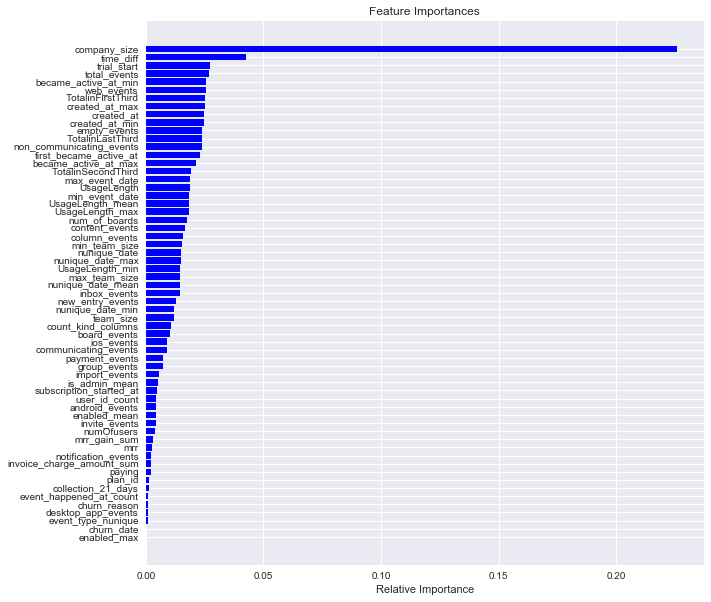

In [47]:
if Rf:
    features=X_train.columns
    importances = RFC.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10,10))
    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')

In [48]:
import xgboost as xgb

if XGB:
   
    gbm = xgb.XGBClassifier(random_state=17)
    y_pred,Model = runModel(gbm,X_train, y_train,X_val,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    print(mcc(y_val, y_pred))
    y_XGB = y_pred.copy()
    XGBModel = Model

C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier running time : 622.417457818985 seconds 


C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy of XGBClassifier on training set: 0.979


C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy of XGBClassifier on test set: 0.979
####################################################################################################
[[254261    784]
 [  4815   1856]]
####################################################################################################
             precision    recall  f1-score   support

          0       0.98      1.00      0.99    255045
          1       0.70      0.28      0.40      6671

avg / total       0.97      0.98      0.97    261716

0.43396054665175643


In [49]:
from catboost import CatBoostClassifier

if CB:
    
    cbc = CatBoostClassifier(random_state=17)
    y_pred,Model = runModel(cbc,X_train, y_train,X_val,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    y_CB = y_pred.copy()

In [50]:
from lightgbm import LGBMModel,LGBMClassifier

if LGBM:
    
    Lgb = LGBMClassifier(random_state=17)
    y_pred,Model = runModel(Lgb,X_train, y_train,X_val,y_val,printaccuracy=True)
    print('#'*100)
    printMetrics(y_val, y_pred)
    print(mcc(y_val, y_pred))
    Y_Lgb = y_pred.copy()
    

C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGBMClassifier running time : 129.12299513816833 seconds 


C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy of LGBMClassifier on training set: 0.981


C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy of LGBMClassifier on test set: 0.980
####################################################################################################
[[253854   1191]
 [  4065   2606]]
####################################################################################################
             precision    recall  f1-score   support

          0       0.98      1.00      0.99    255045
          1       0.69      0.39      0.50      6671

avg / total       0.98      0.98      0.98    261716

0.5087478267681812


# Predict

In [51]:
y_sub = Model.predict(X_test)

C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [52]:
print ("0:" ,np.bincount(y_sub)[0])
print ("1:" ,np.bincount(y_sub)[1])

0: 67805
1: 1010


## leader board results

In [56]:
LoadFroundTruth = 1

if LoadFroundTruth:
    #ground_truth_secret.to_csv('ground_truth_secret.csv') # download file from google colab and save as csv
    ground_truth_secret = pd.read_csv('ground_truth_secret.csv',index_col=[0],header=None)
    #ground_truth_public.to_csv('ground_truth_public.csv') # download file from google colab and save as csv
    ground_truth_public = pd.read_csv('ground_truth_public.csv',index_col=[0],header=None)
    ground_truth_public.index = ground_truth_public.index.astype('int64').astype('str')
    ground_truth_secret.index = ground_truth_secret.index.astype('int64').astype('str')
    
    
if 1:
    
    #prediction to results format:
    
    prediction_series = pd.Series(y_sub,index = X_test.index.astype('int64').astype('str')).rename("lead_score")
    
    if ground_truth_public.index.isin(prediction_series.index).any():
        public_prediction = prediction_series[ground_truth_public.index]
    
    public_prediction = public_prediction.fillna(0).astype('int')

    if ground_truth_secret.index.isin(prediction_series.index).any():
        secret_prediction = prediction_series[ground_truth_secret.index]

    secret_prediction = secret_prediction.fillna(0).astype('int')
    
   

    print (mcc(ground_truth_public, public_prediction),
              mcc(ground_truth_secret, secret_prediction))
    print('--'*17)
    print ("AVG : " , (mcc(ground_truth_public, public_prediction)+
              mcc(ground_truth_secret, secret_prediction))/2)

0.522414421819635 0.5180755442329399
----------------------------------
AVG :  0.5202449830262874


## bagging

In [54]:
bag = 1
testbag = 1


if testbag:
    y_XGB = XGBModel.predict(X_test)
    y_RF = RFModel.predict(X_test)
    Y_Lgb = Model.predict(X_test)
    
    
    
if bag:
    AA = pd.DataFrame(data = {"XGB":y_XGB,"RF":y_RF,"LGBM":Y_Lgb})
    AA['Sum'] = AA.sum(axis = 1).astype("int")
    AA['Sum/3'] = AA['Sum']/3
    print(len(AA[AA['Sum/3']>0.2]))
    print(len(AA[AA['Sum/3']>0.7]))

C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1288
354


In [55]:
if not testbag and bag:
    y_pred = (AA['Sum/3']>0.2).values*1
    print(mcc(y_val, y_pred))

if testbag:
    y_sub = (AA['Sum/3']>0.2).values*1   

# results log

In [59]:
try :
    Logs = pd.read_excel("log.xlsx",index_col=[0])
    display(Logs.head())
except :
    Logs = pd.DataFrame()
    print("file not exist")

,TrainShape,TestShape,ModelName,0 Value,1 Value,Notes,Score,LeaderBoardScore,RF_mcc,NB_mcc
0,"(1089580, 15)","(272396, 15)",LGBMClassifier,270655,1741,Baseline,0.327996,0.287897,0.314285,0.144054
1,"(1047083, 24)","(261771, 24)",LGBMClassifier,259476,2295,Users Baseline,0.353634,0.308732,0.296800,0.144061
2,"(1046863, 58)","(261716, 58)",LGBMClassifier,257904,3812,events Baseline,0.503231,0.483097,0.392189,0.137709
3,"(1046863, 62)","(261716, 62)",LGBMClassifier,257934,3782,subs Baseline,0.503521,0.471862,0.395821,0.131522


In [60]:
import datetime
log = pd.DataFrame()
log.loc[0,'TrainShape'] = str(X_train.shape)
log.loc[0,'TestShape'] = str(X_val.shape)
log.loc[0,'ModelName'] = Model.__class__.__name__
log.loc[0,'0 Value'] = np.bincount(y_pred)[0]
log.loc[0,'1 Value'] = np.bincount(y_pred)[1]
log.loc[0,'Notes'] = " bagging <0.2"
log.loc[0,'Score'] = mcc(y_val, y_pred)
log.loc[0,'LeaderBoardScore'] = (mcc(ground_truth_public, public_prediction)+mcc(ground_truth_secret, secret_prediction))/2
log.loc[0,'RF_mcc'] = RF_mcc
log.loc[0,'NB_mcc'] = NB_mcc

In [61]:
Logs.append(log).reset_index(drop=True).tail()

,TrainShape,TestShape,ModelName,0 Value,1 Value,Notes,Score,LeaderBoardScore,RF_mcc,NB_mcc
0,"(1089580, 15)","(272396, 15)",LGBMClassifier,270655.0,1741.0,Baseline,0.327996,0.287897,0.314285,0.144054
1,"(1047083, 24)","(261771, 24)",LGBMClassifier,259476.0,2295.0,Users Baseline,0.353634,0.308732,0.296800,0.144061
2,"(1046863, 58)","(261716, 58)",LGBMClassifier,257904.0,3812.0,events Baseline,0.503231,0.483097,0.392189,0.137709
3,"(1046863, 62)","(261716, 62)",LGBMClassifier,257934.0,3782.0,subs Baseline,0.503521,0.471862,0.395821,0.131522
4,"(1046863, 61)","(261716, 61)",LGBMClassifier,257919.0,3797.0,bagging <0.2,0.508748,0.520245,0.420534,0.131425


In [62]:
if 1 : #input("insert score ")=='y':
    Logs.append(log).reset_index(drop=True).to_excel("log.xlsx")

In [ ]:
raise Exception ("End")